In [54]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score


from itertools import chain, combinations

sns.set()

In [55]:
# importing and pre-processing

# import data
res = pd.read_csv(
    "data/NEallResults.csv"
)

# split data into data and metadata
res = res.drop(labels=["Group", "Regions"], axis=1) # drop unused data
metadata = res.iloc[:, :4] # select data not used for clustering
data = res.iloc[:, 4:] # select data for clustering

# impute data
data_np = data.to_numpy() # convert to numpy for imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data_np = imp_mean.fit_transform(data_np) # make and fit imputer

#scale data
scaler = preprocessing.MinMaxScaler()
resnorm = pd.DataFrame(scaler.fit_transform(data_np))
resnorm = pd.concat([metadata, resnorm], axis=1)
resnorm.columns = res.columns

# subset to known
known = resnorm[resnorm["Status"].notnull()]

In [56]:
# split known to data and classification target
known_meta = known.iloc[:, :4]
x = known.iloc[:, 5:]  # data for prediction
y = known["Status"]  # classification targets

In [57]:
# get information from various tests of feature importance

feature_importance = pd.DataFrame(columns=["feature", "f val", "f val p-val", "mi"])

feature_importance["feature"] = x.columns

f_class_results = f_classif(x, y)
mi_results = mutual_info_classif(x, y, discrete_features=False)

feature_importance["f val"] = f_class_results[0]
feature_importance["f val p-val"] = f_class_results[1]
feature_importance["mi"] = mi_results


feature_importance



,feature,f val,f val p-val,mi
0,MLsimilarity,0.887026,0.349391,0.005620
1,AAdistance,7.125996,0.009358,0.091326
2,AAsimilarity,5.985981,0.016828,0.000000
3,ZtestDistance,0.092531,0.761849,0.069794
4,ZtestSimilarity,0.215602,0.643793,0.014765
5,Nsdistance,7.220852,0.008919,0.083723
6,Nssimilarity,5.883221,0.017759,0.000000
7,PatristicDistance,5.056820,0.027547,0.080460
8,PatristicSimilarity,0.417659,0.520134,0.000000


In [58]:
# select features by mutual information 

selector = SelectPercentile(mutual_info_classif, percentile=50).fit(x, y)  # create selector
cols = x.columns[selector.get_support(indices=True)]  # get colnames
mi_best_known = selector.transform(x)  # transform to selected features
mi_best_known = pd.DataFrame(mi_best_known)  # convert to df
mi_best_known.columns = cols  # re-add colnames

mi_best_known.head()

,AAdistance,Nsdistance,PatristicDistance,PatristicSimilarity
0,0.024540,0.015811,0.100611,0.537037
1,0.150733,0.135177,0.214386,0.037037
2,0.487836,0.412567,0.313117,0.358025
3,0.338045,0.321436,0.393512,0.111111
4,0.036894,0.023351,0.026798,0.159295


In [59]:
# select features by f value

selector = SelectPercentile(f_classif, percentile=50).fit(x, y)  # create selector
cols = x.columns[selector.get_support(indices=True)]  # get colnames
f_best_known = selector.transform(x)  # transform to selected features
f_best_known = pd.DataFrame(f_best_known)  # convert to df
f_best_known.columns = cols  # re-add colnames

f_best_known.head()

,AAdistance,AAsimilarity,Nsdistance,Nssimilarity
0,0.024540,0.293343,0.015811,0.302313
1,0.150733,0.000000,0.135177,0.000000
2,0.487836,0.000000,0.412567,0.000000
3,0.338045,0.000000,0.321436,0.000000
4,0.036894,0.042640,0.023351,0.043098


In [60]:
def create_kmeans(x, k, weights=None):
    """Create list of cluster ID's using k-means clustering.

    Args:
        x (ndarray): Data to cluster.
        k (int): number of clusters to make

    Returns:
        array: cluster ID's

    """
    # kmeans = make_pipeline(
    #     StandardScaler().fit_transform(),
    #     KMeans(n_clusters=k)
    # )
    kmeans = KMeans(n_clusters=k)

    return kmeans.fit_predict(x, sample_weight=weights)

In [61]:
# out of curiosity, testing these selections with kmeans

def kmeans_graph(df, name, weights=None):
    test = df
    # print(test.iloc[:, 4:].head())
    test.loc[:, "Cluster"] = create_kmeans(test.iloc[:, 4:], 2, weights)

    nmatch1 = test[(test["Status"] == "native") & (test["Cluster"] == 1)].shape[0]
    nmatch0 = test[(test["Status"] == "native") & (test["Cluster"] == 0)].shape[0]
    imatch1 = test[(test["Status"] == "introduced") & (test["Cluster"] == 1)].shape[0]
    imatch0 = test[(test["Status"] == "introduced") & (test["Cluster"] == 0)].shape[0]

    nmatch_choice = 1 if nmatch1 > nmatch0 else 0
    test.loc[:, "Predict"] = ["native" if x == nmatch_choice else "introduced" for x in test["Cluster"]]
    test.loc[:, "Correct"] = test.apply(lambda row: 1 if row["Status"] == row["Predict"] else 0, axis=1)
    
    
    acc = 100 * test["Correct"].sum() / test["Correct"].shape[0]
    nerr = df[(df["Status"] == "native") & (df["Correct"] == 0)].shape[0] / df[df["Status"] == "native"].shape[0] * 100
    ierr = df[(df["Status"] == "introduced") & (df["Correct"] == 0)].shape[0] / df[df["Status"] == "introduced"].shape[0] * 100

    print("Percent of Predictions correct:            {:.2f}%".format(acc))
    print("Percent of Native mislabled to Introduced: {:.2f}%".format(nerr))
    print("Percent of Introduced mislabled to Native: {:.2f}%".format(ierr))

    out = sns.pairplot(
    data=df,
    vars=df.columns[4:-3],
    hue="Predict"
    )
    out.savefig("plots/{}.png".format(name))

In [62]:
# fix resulting index issues for mi test

known_meta = known_meta.reset_index(drop=True)
mi_best_known = mi_best_known.reset_index(drop=True)
mi_test_sheet = pd.concat([known_meta, mi_best_known], axis=1)

Percent of Predictions correct:            72.00%
Percent of Native mislabled to Introduced: 25.37%
Percent of Introduced mislabled to Native: 50.00%


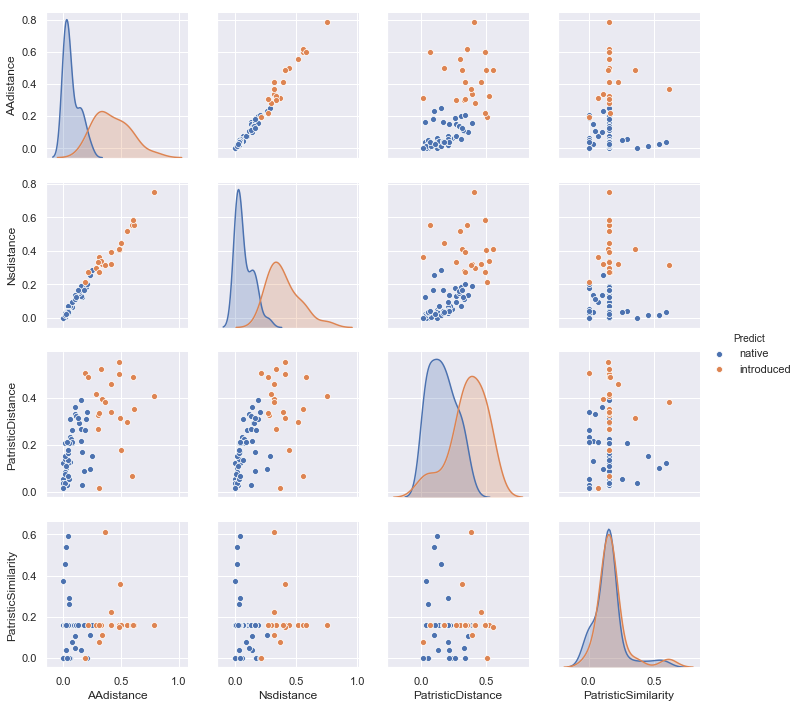

In [63]:
kmeans_graph(mi_test_sheet, "md_cluster_mi_sel_weighted", weights=1/known_meta["N"])

In [64]:
# fix resulting index issues for f test

known_meta = known_meta.reset_index(drop=True)
f_best_known = f_best_known.reset_index(drop=True)
f_test_sheet = pd.concat([known_meta, f_best_known], axis=1)

Percent of Predictions correct:            73.33%
Percent of Native mislabled to Introduced: 23.88%
Percent of Introduced mislabled to Native: 50.00%


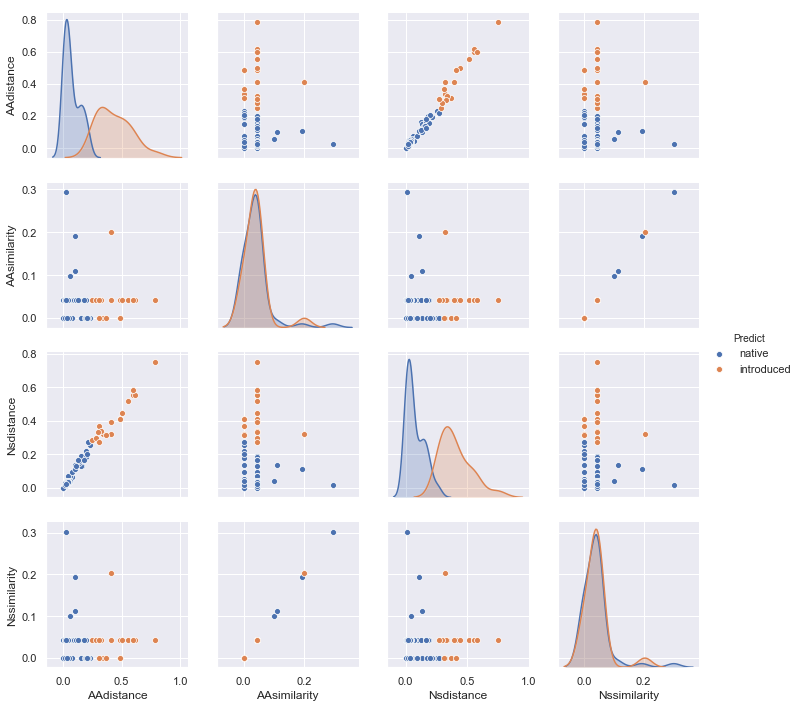

In [65]:
kmeans_graph(f_test_sheet, "md_cluster_f_sel_weighted", weights=1/known_meta["N"])


In [66]:
# split data into test and train data

x = f_best_known
y = known_meta["Status"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, shuffle=True, stratify=y)

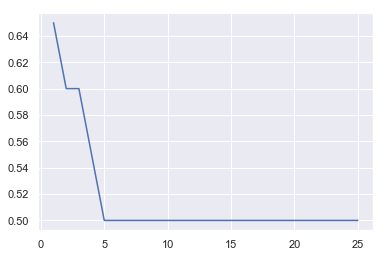

In [76]:
# test knn for optimal k value

scores = []
nerr = []
ierr = []


for k in range(1, 26):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.balanced_accuracy_score(y_test, y_pred))
    res = pd.DataFrame(columns=["Status", "pred", "Correct"])
    res["Status"] = y_test
    res["pred"] = y_pred
    res["Correct"] = res.apply(lambda row: 1 if row["Status"] == row["pred"] else 0, axis=1)

    nerr.append(res[(res["Status"] == "native") & (res["Correct"] == 0)].shape[0] / res[res["Status"] == "native"].shape[0] * 100)
    ierr.append(res[(res["Status"] == "introduced") & (res["Correct"] == 0)].shape[0] / res[res["Status"] == "introduced"].shape[0] * 100)





sns.lineplot(
    x=list(range(1, 26)),
    y=scores
)

    

In [77]:
# take a look at some other measures

results = pd.DataFrame(columns=["k", "acc", "nerr", "ierr"])
results["k"] = list(range(1, 26))
results["acc"] = scores
results["nerr"] = nerr
results["ierr"] = ierr

results

,k,acc,nerr,ierr
0,1,0.65,10.0,60.0
1,2,0.60,20.0,60.0
2,3,0.60,0.0,80.0
3,4,0.55,10.0,80.0
4,5,0.50,0.0,100.0
5,6,0.50,0.0,100.0
6,7,0.50,0.0,100.0
7,8,0.50,0.0,100.0
8,9,0.50,0.0,100.0
9,10,0.50,0.0,100.0


0.553030303030303
k        2.000000
acc      0.553030
nerr    22.727273
ierr    66.666667
Name: 1, dtype: float64


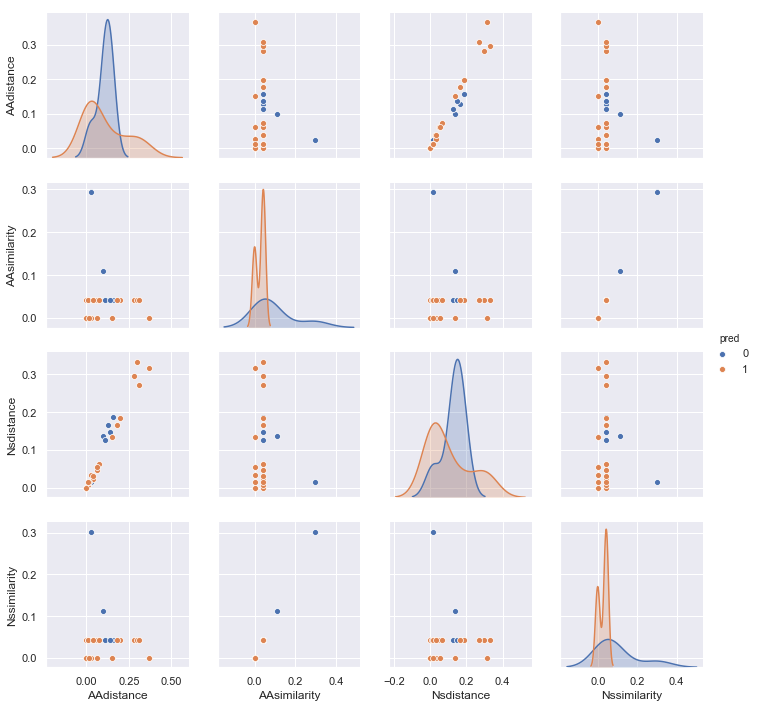

In [69]:
# plot the outcome of the best k



knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

res = pd.DataFrame(columns=["Status", "pred", "Correct"])
res["Status"] = [1 if y == "native" else 0 for y in y_test]
res["pred"] = [1 if y == "native" else 0 for y in y_pred]
res["Correct"] = res.apply(lambda row: 1 if row["Status"] == row["pred"] else 0, axis=1)

res.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
res = pd.concat([x_test, res], axis=1)

print(metrics.balanced_accuracy_score(y_test, y_pred))
print(results.iloc[1])

sns.pairplot(
    data=res,
    vars=res.columns[:4],
    hue="pred",
)



,k,acc,nerr,ierr
0,1,0.65,10.0,60.0
1,2,0.60,20.0,60.0
2,3,0.60,0.0,80.0
3,4,0.55,10.0,80.0
4,5,0.50,0.0,100.0
5,6,0.50,0.0,100.0
6,7,0.50,0.0,100.0
7,8,0.50,0.0,100.0
8,9,0.50,0.0,100.0
9,10,0.50,0.0,100.0


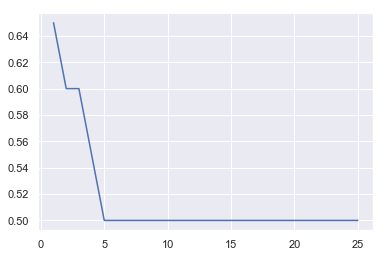

In [70]:
# try everything again but for mi

# split data into test and train data

x = mi_best_known
y = known_meta["Status"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33)
# test knn for optimal k value

scores = []
nerr = []
ierr = []

for k in range(1, 26):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.balanced_accuracy_score(y_test, y_pred))
    
    res = pd.DataFrame(columns=["Status", "pred", "Correct"])
    res["Status"] = y_test
    res["pred"] = y_pred
    res["Correct"] = res.apply(lambda row: 1 if row["Status"] == row["pred"] else 0, axis=1)

    nerr.append(res[(res["Status"] == "native") & (res["Correct"] == 0)].shape[0] / res[res["Status"] == "native"].shape[0] * 100)
    ierr.append(res[(res["Status"] == "introduced") & (res["Correct"] == 0)].shape[0] / res[res["Status"] == "introduced"].shape[0] * 100)


sns.lineplot(
    x=list(range(1, 26)),
    y=scores
)

# take a look at some other measures

results = pd.DataFrame(columns=["k", "acc", "nerr", "ierr"])
results["k"] = list(range(1, 26))
results["acc"] = scores
results["nerr"] = nerr
results["ierr"] = ierr

results

let's redo the test for f values with more rigourous methods

In [71]:
# a helper function for getting an mean balanced accuracy

def xeval(classifier, x, y, folds):
    """Cross-validate a classifier.

    Args:
        classifier (varies): A classifier
        x (ndarray): Test data.
        y (series): Class values.
        folds (int): Number of folds to use.

    Returns:
        float: Mean accuracy.

    """
    return cross_val_score(classifier, x, y, cv=folds, scoring="balanced_accuracy").mean()

[0.65, 0.425, 0.8, 0.825, 0.7, 0.7, 0.7, 0.7, 0.75, 0.75]


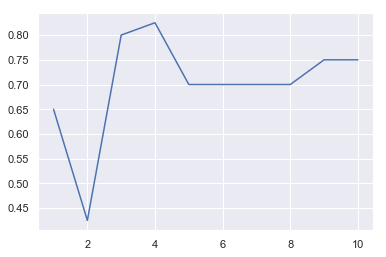

In [72]:
scores = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    scores.append(xeval(knn, x_test, y_test, folds=10))

print(scores)
    
sns.lineplot(
    x=list(range(1, 11)),
    y=scores
)

0.55
    AAdistance  Nsdistance  PatristicDistance  PatristicSimilarity  Status  \
0     0.162159    0.167233           0.170663             0.159295       1   
1     0.019174    0.031340           0.139633             0.159295       1   
2     0.012587    0.016180           0.149977             0.456790       1   
3     0.012242    0.015532           0.083216             0.159295       1   
4     0.365908    0.315669           0.378974             0.612536       1   
5     0.054651    0.042673           0.208247             0.292756       1   
6     0.283176    0.294659           0.416079             0.159295       1   
7     0.062352    0.055082           0.233662             0.000000       1   
8     0.000000    0.000000           0.026798             0.000000       1   
9     0.136201    0.159021           0.291961             0.159295       0   
10    0.189206    0.175722           0.262341             0.000000       1   
11    0.098828    0.136208           0.358110             0

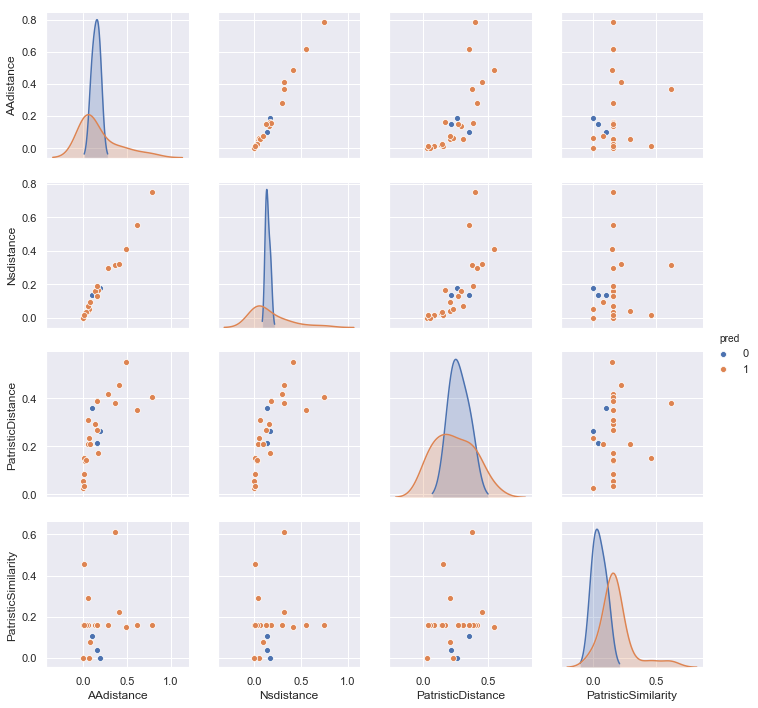

In [74]:
# plot the outcome of the best k



knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

res = pd.DataFrame(columns=["Status", "pred", "Correct"])
res["Status"] = [1 if y == "native" else 0 for y in y_test]
res["pred"] = [1 if y == "native" else 0 for y in y_pred]
res["Correct"] = res.apply(lambda row: 1 if row["Status"] == row["pred"] else 0, axis=1)

res.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
res = pd.concat([x_test, res], axis=1)

print(metrics.balanced_accuracy_score(y_test, y_pred))

print(res)

sns.pairplot(
    data=res,
    vars=res.columns[:4],
    hue="pred",
)